In [1]:
import numpy as np
import cv2

In [2]:
def add_gaussian_noise(img, sigma):
    if np.max(img) > 1:
        img = img / 255.0

    sigma_norm = sigma / 255.0
    zg = np.random.normal(0, sigma_norm, img.shape)
    img_zg = img + zg
    img_zg = np.clip(img_zg, 0, 1)

    return img_zg


In [3]:
def add_impulsive_noise(img, p0, p1):
    if np.max(img) > 1:
        img = img / 255.0
        
    imgzg = img.copy()
    [L, C, pl] = np.shape(img)
    
    for plan in range(pl):
        coord_L_0 = np.random.randint(0, L, int(p0 * L * C))
        coord_C_0 = np.random.randint(0, C, int(p0 * L * C))
        imgzg[coord_L_0, coord_C_0, plan] = 0

        coord_L_1 = np.random.randint(0, L, int(p1 * L * C))
        coord_C_1 = np.random.randint(0, C, int(p1 * L * C))
        imgzg[coord_L_1, coord_C_1, plan] = 1
        
    return imgzg


In [4]:
from scipy import signal

def median_filter_color(img, W=1): 
    if np.max(img) > 1:
        img = img / 255.0
        
    [L, C, pl] = np.shape(img)
    img_out = np.zeros((L, C, pl))
    dim = 2 * W + 1

    kernel_bordare = np.zeros((dim, dim))
    kernel_bordare[W, W] = 1
    
    for plan in range(pl):
        img_bordat = signal.convolve2d(img[:,:,plan], kernel_bordare, 'full', 'symm')
        
        for l in range(W, L + W):
            for c in range(W, C + W):
                vecinatate = img_bordat[l-W : l+W+1, c-W : c+W+1]
                img_out[l-W, c-W, plan] = np.median(vecinatate)
                
    return (img_out * 255).astype(np.uint8)

In [5]:
def mean_filter_color(img, size=3):
    if np.max(img) > 1:
        img = img / 255.0
        
    [L, C, pl] = np.shape(img)
    img_out = np.zeros((L, C, pl))
    nucleu = np.ones((size, size)) / (size**2)
    W = size // 2
    
    kernel_bordare = np.zeros((size, size))
    kernel_bordare[W, W] = 1
    
    for plan in range(pl):
        img_bordat = signal.convolve2d(img[:,:,plan], kernel_bordare, 'full', 'symm')
        
        for l in range(W, L + W):
            for c in range(W, C + W):
                vecinatate = img_bordat[l-W : l+W+1, c-W : c+W+1]
                img_out[l-W, c-W, plan] = np.sum(nucleu * vecinatate)
                
    return (img_out * 255).astype(np.uint8)

In [6]:
def rgb_to_hsi(img):
    if np.max(img) > 1:
        img = img / 255.0

    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    I = (R + G + B) / 3

    S = 1 - (3 / (R + G + B + 1e-6)) * np.minimum(np.minimum(R, G), B)
    S = np.clip(S, 0, 1) 

    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B)) + 1e-6
    theta = np.arccos(np.clip(num / den, -1, 1))

    H = np.zeros_like(theta)
    H[B <= G] = theta[B <= G]
    H[B > G] = 2*np.pi - theta[B > G]
    H = H / (2*np.pi)

    return H, S, I


In [7]:
def hsi_to_rgb(H, S, I):
    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)

    H = H * 2*np.pi

    # Sector 0–120
    idx = (H < 2*np.pi/3)
    B[idx] = I[idx] * (1 - S[idx])
    R[idx] = I[idx] * (1 + (S[idx]*np.cos(H[idx])) /
                       (np.cos(np.pi/3 - H[idx]) + 1e-6))
    G[idx] = 3*I[idx] - (R[idx] + B[idx])

    # Sector 120–240
    idx = (H >= 2*np.pi/3) & (H < 4*np.pi/3)
    H2 = H[idx] - 2*np.pi/3
    R[idx] = I[idx] * (1 - S[idx])
    G[idx] = I[idx] * (1 + (S[idx]*np.cos(H2)) /
                       (np.cos(np.pi/3 - H2) + 1e-6))
    B[idx] = 3*I[idx] - (R[idx] + G[idx])

    # Sector 240–360
    idx = (H >= 4*np.pi/3)
    H3 = H[idx] - 4*np.pi/3
    G[idx] = I[idx] * (1 - S[idx])
    B[idx] = I[idx] * (1 + (S[idx]*np.cos(H3)) /
                       (np.cos(np.pi/3 - H3) + 1e-6))
    R[idx] = 3*I[idx] - (G[idx] + B[idx])

    img_rgb = np.stack((R, G, B), axis=2)
    img_rgb = np.clip(img_rgb, 0, 1)

    return img_rgb


In [8]:
import numpy as np
from scipy.signal import convolve2d

def homomorphic_spatial_3x3(I, k=1.0, out_gamma=0.85,
                                     use_percentile=True, p_lo=2, p_hi=98,
                                     use_mean_preserve=True):
   
    I = np.clip(I, 0, 1).astype(np.float32)

    L = np.log1p(I)

    hp = np.array([[-1,-1,-1],
                   [-1, 9,-1],
                   [-1,-1,-1]], dtype=np.float32) / 8.0
    delta = np.zeros((3,3), dtype=np.float32)
    delta[1,1] = 1.0

    K_eff = delta + k * hp

    Lf = convolve2d(L, K_eff, mode="same", boundary="symm")

    I_out = np.expm1(Lf)
    I_out = np.clip(I_out, 0, None)

    if use_mean_preserve:
        I_out *= (np.mean(I) / (np.mean(I_out) + 1e-12))

    I_out = np.clip(I_out, 0, 1)

    if use_percentile:
        lo, hi = np.percentile(I_out, (p_lo, p_hi))
        I_out = np.clip((I_out - lo) / (hi - lo + 1e-12), 0, 1)

    if out_gamma is not None:
        I_out = np.clip(I_out, 0, 1) ** out_gamma

    return np.clip(I_out, 0, 1)



In [9]:
import numpy as np

def homomorphic_hsi_color(img_rgb, k=1.0, out_gamma=0.85,
                          use_percentile=True, p_lo=2, p_hi=98,
                          use_mean_preserve=True,
                          brightness_gain=1.0, gamma_post=None,
                          to_uint8=True):

    img = img_rgb.astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0

    H, S, I = rgb_to_hsi(img)

    I_enh = homomorphic_spatial_3x3(
        I,
        k=k,
        out_gamma=out_gamma,
        use_percentile=use_percentile, p_lo=p_lo, p_hi=p_hi,
        use_mean_preserve=use_mean_preserve
    )

    if brightness_gain is not None and brightness_gain != 1.0:
        I_enh = np.clip(I_enh * float(brightness_gain), 0, 1)

    if gamma_post is not None:
        I_enh = np.clip(I_enh, 0, 1) ** float(gamma_post)

    out = hsi_to_rgb(H, S, I_enh)
    out = np.clip(out, 0, 1)

    if to_uint8:
        return (out * 255).astype(np.uint8)
    return out


TABEL REZULTATE:
Medie   | PSNR:  32.61 dB | MAE:   0.0152 | SSIM:   0.8753
Median  | PSNR:  31.52 dB | MAE:   0.0141 | SSIM:   0.8600
Omomorfic | PSNR:  19.60 dB | MAE:   0.0842 | SSIM:   0.7974


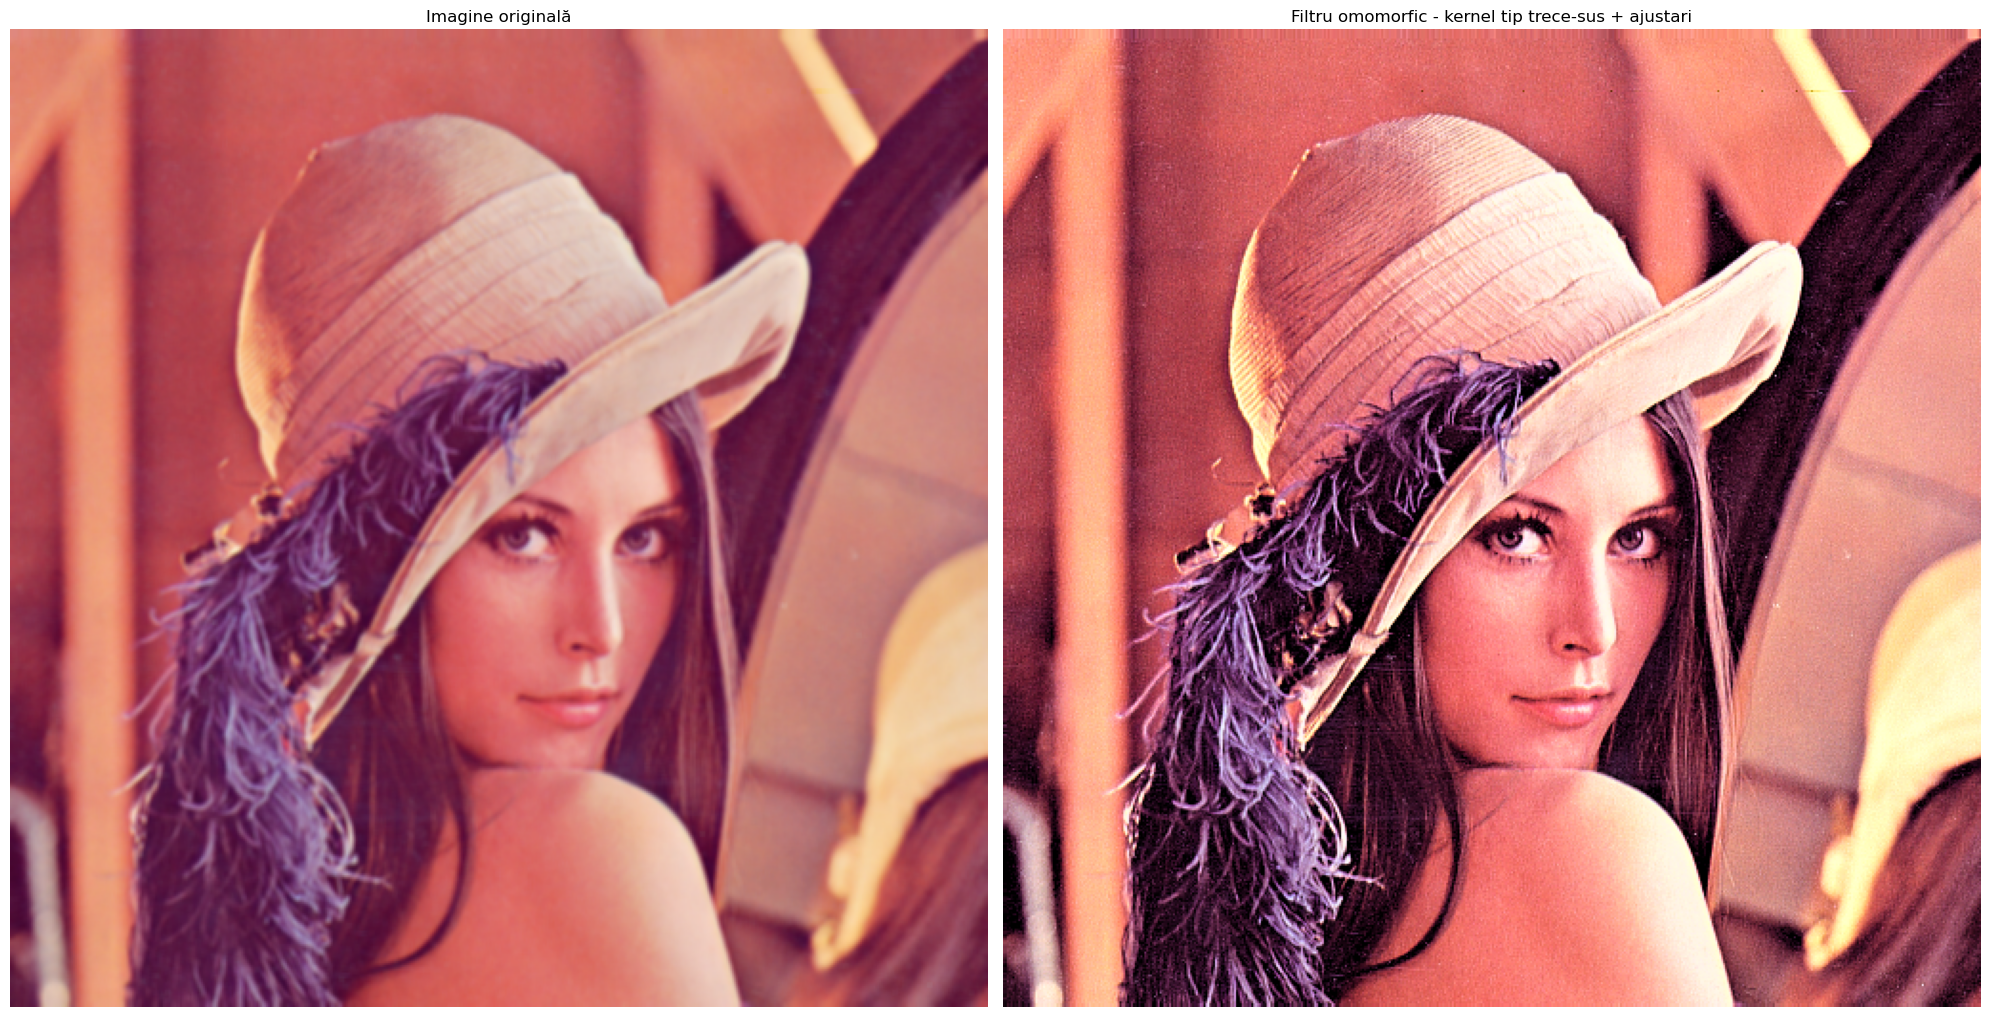

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage.metrics import structural_similarity as ssim_skimage

def psnr(img_ref, img_test):
    img_ref = img_ref.astype(np.float32)
    img_test = img_test.astype(np.float32)

    if np.max(img_ref) > 1:
        img_ref = img_ref / 255.0
    if np.max(img_test) > 1:
        img_test = img_test / 255.0

    mse = np.mean((img_ref - img_test) ** 2)
    if mse == 0:
        return np.inf
    return 10 * np.log10(1.0 / mse)


def calculate_mae(img_ref, img_test):
    img1 = img_ref.astype(np.float32) / 255.0 if np.max(img_ref) > 1 else img_ref.astype(np.float32)
    img2 = img_test.astype(np.float32) / 255.0 if np.max(img_test) > 1 else img_test.astype(np.float32)
    return float(np.mean(np.abs(img1 - img2)))


def calculate_ssim(img_ref, img_test):
    img1 = img_ref.astype(np.float32) / 255.0 if np.max(img_ref) > 1 else img_ref.astype(np.float32)
    img2 = img_test.astype(np.float32) / 255.0 if np.max(img_test) > 1 else img_test.astype(np.float32)
    return float(ssim_skimage(img1, img2, channel_axis=2, data_range=1.0))


def _to_uint8_rgb(img_rgb):
    if img_rgb.dtype == np.uint8:
        return img_rgb
    if np.max(img_rgb) <= 1.0:
        return (np.clip(img_rgb, 0, 1) * 255).astype(np.uint8)
    return np.clip(img_rgb, 0, 255).astype(np.uint8)

img_orig = io.imread(r"C:\Users\Robi\Desktop\PROIECT PAIC\img\lena.png") #couple.png, monarch, lena, fruits, pens, sailboat, yacht
if img_orig.ndim == 3 and img_orig.shape[2] == 4:
    img_orig = img_orig[:, :, :3]

#img_zg = add_gaussian_noise(img_orig, 35); # 15, 25, 35
img_zg = add_impulsive_noise(img_orig, 0.075, 0.075); #0.02, 0.04, 0.075 


img_medie = mean_filter_color(img_orig) #img_zg
img_median = median_filter_color(img_zg)
img_homo = homomorphic_hsi_color(img_orig) #img_zg

metrici = {
    "Medie":  (psnr(img_orig, img_medie),
               calculate_mae(img_orig, img_medie),
               calculate_ssim(img_orig, img_medie)),
    "Median": (psnr(img_orig, img_median),
               calculate_mae(img_orig, img_median),
               calculate_ssim(img_orig, img_median)),
    "Omomorfic": (psnr(img_orig, img_homo),
               calculate_mae(img_orig, img_homo),
               calculate_ssim(img_orig, img_homo))
}

print("TABEL REZULTATE:")
for metoda, (p, m, s) in metrici.items():
    print(f"{metoda:7s} | PSNR: {p:6.2f} dB | MAE: {m:8.4f} | SSIM: {s:8.4f}")

plt.figure(figsize=(20, 12))
#plt.subplot(2, 3, 1), plt.imshow(img_orig), plt.title("Imagine originală"), plt.axis('off')
#plt.subplot(2, 3, 2), plt.imshow(img_zg), plt.title("Imagine cu zgomot impulsiv"), plt.axis('off')
#plt.subplot(2, 3, 4), plt.imshow(img_medie), plt.title("Filtru medie aritmetica"), plt.axis('off')
#plt.subplot(2, 3, 5), plt.imshow(img_median), plt.title("Filtru median"), plt.axis('off')
#plt.subplot(2, 3, 6), plt.imshow(img_homo), plt.title("Filtru omomorfic - kernel tip trece-sus + ajustari"), plt.axis('off')
plt.subplot(1, 2, 1), plt.imshow(img_medie), plt.title("Imagine originală"), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(img_homo), plt.title("Filtru omomorfic - kernel tip trece-sus + ajustari"), plt.axis('off')
plt.tight_layout()
plt.show()
